In [2]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings, traceback

from IndexUtils import * 
from TileUtils import *
from featurematching import *
from ReadDate import *
from concurrent.futures import ThreadPoolExecutor

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist
import easyocr
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


%load_ext autoreload
%autoreload 2

C:\Users\fhacesga\AppData\Local\Temp\ipykernel_29560\3096312912.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [3]:
def processHalfSize(tiles, half_path):
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

def processSAHIresults(yolo_path, streetcorner_out_fn):
    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else "exp"
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict
    

def processTiledYOLOs(tiles, model_paths, out_dict_names, proc_dir, imsizes, hide_labels=None, thresholds=None):

    if hide_labels is None:
        hide_labels = [True] * len(imsizes)
    
    if thresholds is None:
        thresholds  = [0.05] * len(imsizes)

    print("Making images half size for tiled inference")
    half_path = os.path.join(proc_dir, "half_size")
    os.makedirs(half_path, exist_ok=True)
    processHalfSize(tiles, half_path)
    
    out_dicts = []

    for i, model_path in enumerate(model_paths): 

        yolo_path = os.path.join(proc_dir, out_dict_names[i])
        os.makedirs(yolo_path, exist_ok=True)

        out_fn = os.path.join(proc_dir, f"{out_dict_names[i]}.pkl")
        
        if not os.path.exists(out_fn):
            
            detection_model = AutoDetectionModel.from_pretrained(
                model_type="yolov8",
                model_path=model_path,
                confidence_threshold=thresholds[i],
                device="cuda",  # or 'cuda:0'
            )
            
            result = predict(source=half_path,
                            detection_model=detection_model, 
                            verbose=0, 
                            project=yolo_path,
                            slice_height=imsizes[i], 
                            slice_width=imsizes[i], 
                            model_device="cuda", 
                            return_dict=True, 
                            export_pickle=True,
                            visual_hide_labels=hide_labels[i])
            
            curr_dict = processSAHIresults(yolo_path, out_fn)
        else:
            print(f"Reading from {out_fn}")
            curr_dict = pickle.load(open(out_fn, "rb"))

        out_dicts.append(curr_dict)
    
    return out_dicts


In [4]:
base_input_path = r"D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\\"
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201', '480296']

for w in wildcards:
    # print(f"Potential detections {w}: {len([a for a in list(tile_coords.keys()) if w in a])}")
    # print([a for a in list(tile_coords.keys()) if w in a])
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

In [5]:
model_paths = [
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
]
# model_paths = [
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt"
# ]

proc_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\newtest\\"

out = processTiledYOLOs(tiles, model_paths, ['CornerCoordinates', 'StreetCorners'], proc_dir, imsizes=[256, 320], hide_labels=[False, True], thresholds=[0.3, 0.05])

Making images half size for tiled inference


  0%|          | 0/10 [00:00<?, ?it/s]

Performing inference on images: 100%|██████████| 10/10 [04:08<00:00, 24.89s/it]


Prediction results are successfully exported to D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\newtest\CornerCoordinates\exp
Reading results from: D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\newtest\\CornerCoordinates\exp\pickles\


Performing inference on images: 100%|██████████| 10/10 [03:00<00:00, 18.05s/it]

Prediction results are successfully exported to D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\newtest\StreetCorners\exp
Reading results from: D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\CornerFiles\newtest\\StreetCorners\exp\pickles\


In [ ]:
"""
ori_model = TPNN(num_classes=3, finalpadding=1, inputsize=2)
ori_checkpoint = torch.load(r'C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FLNN/checkpoint_021524.pth')
ori_model.load_state_dict(ori_checkpoint['model_state_dict'])

checkpoint = torch.load(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FLNN\checkpoint_111824_tiled_2.pth")
model = WrapperTPNN(ori_model, input_channels=1, target_channels=2)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')
"""

In [6]:
from TPNN import *

In [7]:
def split_and_run_cnn_wrapper(image, model, tilesize=512, device="cuda", verbose=True):

    tensor = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # CALCULATE HOW MANY TILES WE NEED IN X AND Y DIRECTIONS
    width, height = image.shape
    num_tiles_x = (width + tilesize-1) // tilesize
    num_tiles_y = (height + tilesize-1) // tilesize
    
    # OUTPUT STRUCTURES
    output_tiles = []
    output_gen = np.zeros((width, height, model.tpnn.num_classes))
    
    # FOR EACH TILE
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
                        
            # COORDINATES OF CURRENT TILE
            x0 = tile_x * tilesize
            y0 = tile_y * tilesize
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)
            x_pad = x1 - x0
            y_pad = y1 - y0

            print(x0, x1, y0, y1, x_pad, y_pad)
            tile = np.zeros((tilesize, tilesize))
            tile[:x_pad, :y_pad] = image[x0:x1, y0:y1]
            
            # TILE PREPROCESSING
            tile = np.array(tile)                               # AS NUMPY ARRAY
            tile = tile * 255 if np.max(tile) == 1 else tile    # SCALE TO UINT 8
            tile = tile.astype(np.uint8)                        # CHANGE DATA TYPE
            tile_tensor = tensor(tile).unsqueeze(0).to(device)  # TO DEVICE

            # RUN CNN ON TILE
            output = model(tile_tensor)
            
            # PROCESS OUTPUTS OUT OF DEVICE
            if device == "cuda":
                output = output[0, :, :, :].cpu().detach().numpy()
            else:
                output = output[0, :, :, :].detach().numpy()
            
            # POSTPROCESS 
            output = np.moveaxis(output, [0], [2])                      # CHANGE CHANNELS SO BANDS ARE IN LAST DIMENSION
            output_tiles.append(output.copy())                          # APPEND TILE TO LIST
            
            # PUT IT WITH THE REST
            output_gen[x0:x1, y0:y1, :] = output[:x_pad, :y_pad, :]
        
        del output, tile, tile_tensor
        torch.cuda.empty_cache()
    return output_gen, output_tiles

def split_and_run_cnn_with_overlap(image, model, tilesize=512, overlap=256, device="cuda", verbose=True):
    import torch
    import numpy as np
    from tqdm import tqdm
    from torchvision import transforms

    tensor = transforms.Compose([transforms.ToTensor()])

    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # Calculate dimensions and overlap-adjusted tile stepping
    width, height = image.shape
    step = tilesize - overlap  # Step size accounting for overlap

    # Calculate how many steps in X and Y directions
    num_tiles_x = (width - overlap + step - 1) // step
    num_tiles_y = (height - overlap + step - 1) // step

    # Prepare output and counters
    output_gen = np.zeros((width, height, model.tpnn.num_classes), dtype=np.float32)
    counts = np.zeros((width, height), dtype=np.float32)

    # Process each tile
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
            # Compute tile coordinates
            x0 = tile_x * step
            y0 = tile_y * step
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)

            # Extract the current tile
            tile = np.zeros((tilesize, tilesize), dtype=image.dtype)
            tile[:x1 - x0, :y1 - y0] = image[x0:x1, y0:y1]

            # Preprocess tile
            tile_tensor = tensor(tile).unsqueeze(0).to(device)

            # Run CNN on tile
            output = model(tile_tensor)
            if device == "cuda":
                output = output[0].cpu().detach().numpy()
            else:
                output = output[0].detach().numpy()

            # Add to output structure
            output = np.moveaxis(output, 0, -1)  # Rearrange channels to last dimension
            output_gen[x0:x1, y0:y1, :] += output[:x1 - x0, :y1 - y0, :]
            counts[x0:x1, y0:y1] += 1  # Increment overlap counts

    # Normalize by counts to average overlapping regions
    output_gen /= np.expand_dims(counts, axis=-1)

    return output_gen, counts

def run_nontiled_CNN(image_fn, model, runsize=1536, device="cuda"):
    
    tensor = transforms.Compose([transforms.ToTensor()])

    image = Image.open(image_fn).convert('L')
    image = cv2.resize(np.array(image).astype(np.uint8), (runsize, runsize), interpolation= cv2.INTER_AREA)            
    image = Image.fromarray(np.array(image).astype(np.uint8))
    

    image_tensor = tensor(image).unsqueeze(0).to(device)

    output = model(image_tensor)
    if device == "cuda":
        output = output[0].cpu().detach().numpy()
    else:
        output = output[0].detach().numpy()

    return output, model

    

In [8]:
model = TPNN(num_classes=2, finalpadding=0, inputsize=1)
checkpoint = torch.load(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\checkpoint_112424_nontiled.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to("cuda")

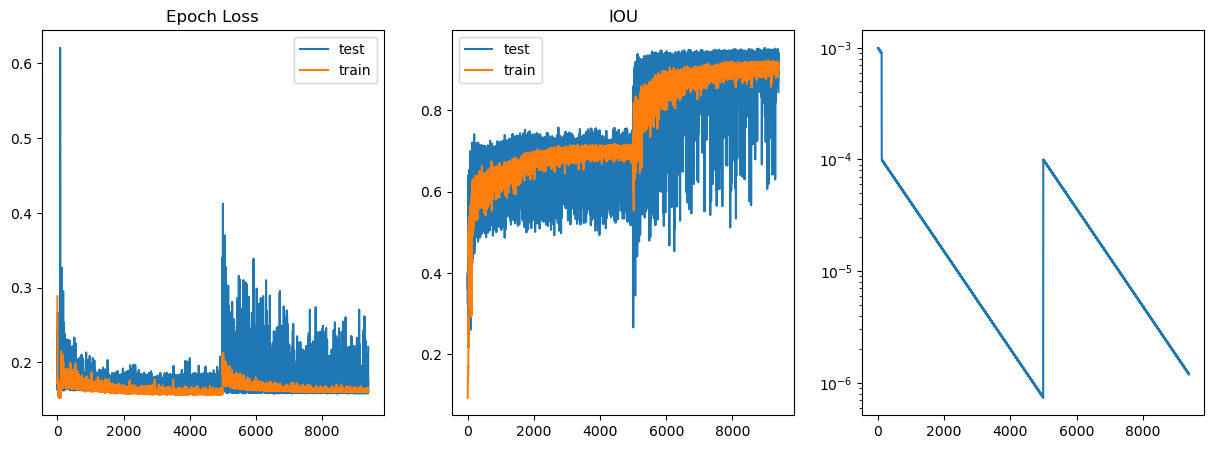

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5 ))

axs[0].plot(np.array(checkpoint['epoch_losses']['test'])/2, label='test')
axs[0].plot(np.array(checkpoint['epoch_losses']['train']),  label='train')
axs[0].set_title("Epoch Loss")
axs[0].legend()

axs[1].plot(np.array(checkpoint['iou_lists']['test'])[:, 1], label='test')
axs[1].plot(np.array(checkpoint['iou_lists']['train'])[:, 1], label='train')
axs[1].set_title("IOU")
axs[1].legend()

axs[2].plot(checkpoint['lr_list'])
axs[2].set_yscale('log')

In [10]:
# mydir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\referencing\\"
mydir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\ImportantIshFiles\\"
files = glob.glob(f"{mydir}*.tif")

out_dir = f"{mydir}out\\"

os.makedirs(out_dir, exist_ok=True)

for file_dir in files:
    ou_dir = os.path.join(out_dir, os.path.basename(file_dir))

    image = Image.open(file_dir).convert('L')
    image = np.asarray(image)
    original_shape = image.shape
    
    test, model = run_nontiled_CNN(file_dir, model)

    test = test * 255
    test = test.astype(np.uint8)

    test = cv2.resize(test[1, :, :], (original_shape[1], original_shape[0]), interpolation= cv2.INTER_LINEAR)

    cv2.imwrite(ou_dir, test)

['D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0835J.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0855J.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0845J.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0845K.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0835K.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0865L.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0845L.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0855K.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0865K.tif',
 'D:\\RECTDNN\\processing\\2024-11-15_09-31-24\\ImportantIshFiles\\CornerFiles\\48201C0865J.tif']

In [74]:
def get_image_sectors(image_width, image_height, coordinates):
    """
    Determine which sector of an image each coordinate belongs to.

    Parameters:
        image_width (int): Width of the image.
        image_height (int): Height of the image.
        coordinates (list or numpy array): Nx2 array of (x, y) coordinates.

    Returns:
        list: A list of sectors for each coordinate.
              Each sector is one of ['top left', 'top right', 'bottom left', 'bottom right'].
    """
    sectors = []
    mid_x, mid_y = image_width / 2, image_height / 2

    for x, y in coordinates:
        if x < mid_x and y < mid_y:
            sectors.append("top left")
        elif x >= mid_x and y < mid_y:
            sectors.append("top right")
        elif x < mid_x and y >= mid_y:
            sectors.append("bottom left")
        else:  # x >= mid_x and y >= mid_y
            sectors.append("bottom right")
    
    return sectors

def all_sectors_present(sectors):
    """
    Check if all four image sectors are present in the given list.

    Parameters:
        sectors (list): A list of sectors, e.g., ['top left', 'top right', 'bottom left', 'bottom right'].

    Returns:
        bool: True if all sectors are present, False otherwise.
    """
    required_sectors = {'top left', 'top right', 'bottom left', 'bottom right'}
    return required_sectors.issubset(set(sectors))

def group_coordinates_by_sector(coordinates, sectors):
    """
    Group coordinates by sector.

    Parameters:
        coordinates (list or numpy array): Nx2 array of (x, y) coordinates.
        sectors (list): List of sector names corresponding to each coordinate.

    Returns:
        dict: A dictionary with sector names as keys and lists of coordinates as values.
    """
    sector_coordinates = {
        "top left": [],
        "top right": [],
        "bottom left": [],
        "bottom right": []
    }
    for coord, sector in zip(coordinates, sectors):
        sector_coordinates[sector].append(coord)
    return sector_coordinates

def compute_sector_center(coords):
    """
    Compute the center of a group of coordinates.

    Parameters:
        coords (numpy array): Array of (x, y) coordinates.

    Returns:
        tuple: (center_x, center_y) representing the center of the coordinates.
    """
    return coords[:, 0].mean(), coords[:, 1].mean()

def compute_bounding_box(coords, center_x, center_y, min_width, min_height, buffer):
    """
    Compute the bounding box for a sector given its coordinates.

    Parameters:
        coords (numpy array): Array of (x, y) coordinates in the sector.
        center_x (float): Center x-coordinate of the sector.
        center_y (float): Center y-coordinate of the sector.
        min_width (float): Minimum width of the bounding box.
        min_height (float): Minimum height of the bounding box.
        buffer (float): Additional buffer around the bounding box.

    Returns:
        tuple: Bounding box in the format (x_min, y_min, x_max, y_max).
    """
    x_min = min(coords[:, 0]) - buffer
    x_max = max(coords[:, 0]) + buffer
    y_min = min(coords[:, 1]) - buffer
    y_max = max(coords[:, 1]) + buffer

    # Ensure the bounding box has at least the minimum dimensions
    if x_max - x_min < min_width:
        delta = (min_width - (x_max - x_min)) / 2
        x_min = center_x - min_width / 2
        x_max = center_x + min_width / 2
    if y_max - y_min < min_height:
        delta = (min_height - (y_max - y_min)) / 2
        y_min = center_y - min_height / 2
        y_max = center_y + min_height / 2

    return x_min, y_min, x_max, y_max

def compute_bounding_boxes(coordinates, sectors, min_width, min_height, buffer=0):
    """
    Main function to compute bounding boxes for all sectors.

    Parameters:
        coordinates (list or numpy array): Nx2 array of (x, y) coordinates.
        sectors (list): List of sector names corresponding to each coordinate.
        min_width (float): Minimum width of the bounding box.
        min_height (float): Minimum height of the bounding box.
        buffer (float): Additional buffer around the bounding box.

    Returns:
        dict: A dictionary where keys are sector names, and values are bounding box tuples
              in the format (x_min, y_min, x_max, y_max).
    """
    sector_coordinates = group_coordinates_by_sector(coordinates, sectors)
    sector_bboxes = {}

    for sector, coords in sector_coordinates.items():
        if not coords:
            # Skip if no coordinates in this sector
            continue

        coords = np.array(coords)
        center_x, center_y = compute_sector_center(coords)
        bbox = compute_bounding_box(coords, center_x, center_y, min_width, min_height, buffer)
        sector_bboxes[sector] = bbox

    return sector_bboxes

def extract_bounding_boxes(image, bounding_boxes):
    """
    Extract regions of an image corresponding to the given bounding boxes.

    Parameters:
        image (numpy array): The input image as a NumPy array (H x W x C for color or H x W for grayscale).
        bounding_boxes (dict): A dictionary where keys are sector names and values are bounding box tuples
                               in the format (x_min, y_min, x_max, y_max).

    Returns:
        dict: A dictionary where keys are sector names and values are cropped image regions (numpy arrays).
    """
    cropped_images = {}
    for sector, (x_min, y_min, x_max, y_max) in bounding_boxes.items():
        # Ensure bounding box values are integers and within image bounds
        x_min = max(0, int(x_min))
        y_min = max(0, int(y_min))
        x_max = min(image.shape[1], int(x_max))
        y_max = min(image.shape[0], int(y_max))
        
        # Crop the image region
        cropped_images[sector] = image[y_min:y_max, x_min:x_max]

    return cropped_images

out_sectors = {}
for tile in tiles:
    key = os.path.basename(tile).split(".")[0] + ".pickle"
    coordinates = out[0][key] * 2

    im      = cv2.imread(tile)
    im_arry = np.asarray(im)

    print(key)

    im_sectors = get_image_sectors(im_arry.shape[0], im_arry.shape[1], coordinates)
    print(im_sectors)
    if all_sectors_present(im_sectors):
        out_sectors[key] = {}
        out_sectors[key]['bboxes'] = compute_bounding_boxes(coordinates, im_sectors, 800, 400, buffer=200)
        out_sectors[key]['images'] = extract_bounding_boxes(im_arry, out_sectors[key]['bboxes'])


48201C0835J.pickle
['top right', 'bottom right', 'top left', 'bottom left']
48201C0855J.pickle
['bottom right', 'top right', 'top left', 'bottom left']
48201C0845J.pickle
['top right', 'top left', 'bottom left', 'bottom right', 'bottom left', 'top right']
48201C0845K.pickle
['top left', 'top right', 'bottom right', 'bottom left']
48201C0835K.pickle
['bottom right', 'top right', 'bottom left', 'top right', 'top left']
48201C0865L.pickle
[]
48201C0845L.pickle
[]
48201C0855K.pickle
['top right', 'top left', 'bottom right', 'bottom left']
48201C0865K.pickle
['bottom right', 'top right', 'top left', 'bottom left']
48201C0865J.pickle
['bottom right', 'top right', 'top left', 'bottom left', 'bottom left']


In [35]:
try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [75]:
out_sectors.keys()

dict_keys(['48201C0835J.pickle', '48201C0855J.pickle', '48201C0845J.pickle', '48201C0845K.pickle', '48201C0835K.pickle', '48201C0855K.pickle', '48201C0865K.pickle', '48201C0865J.pickle'])

48201C0835J.pickle
{'top left': {'lon': 95.5625, 'lat': 29.75}, 'top right': {'lon': 95.5, 'lat': 29.75}, 'bottom left': {'lon': 95.5625, 'lat': 29.6875}, 'bottom right': {'lon': 95.5, 'lat': 29.6875}}
48201C0855J.pickle
{'top left': {'lon': 95.5, 'lat': 29.75}, 'top right': {'lon': 95.4375, 'lat': 29.75}, 'bottom left': {'lon': 95.5, 'lat': 29.6875}, 'bottom right': {'lon': 95.4375, 'lat': 29.6875}}
48201C0845J.pickle
{'top left': {'lon': 95.5625, 'lat': 29.6875}, 'top right': {'lon': 97.125, 'lat': 32.375}, 'bottom left': {'lon': 95.5625, 'lat': 29.625}, 'bottom right': {'lon': 95.5, 'lat': 29.625}}
48201C0845K.pickle
{'top left': {'lon': 95.5625, 'lat': 29.6875}, 'top right': {'lon': 95.5, 'lat': 29.6875}, 'bottom left': {'lon': 95.5625, 'lat': 29.625}, 'bottom right': {'lon': 95.5, 'lat': 29.625}}
48201C0835K.pickle
{'top left': {'lon': 95.5625, 'lat': 29.75}, 'top right': {'lon': 97.125, 'lat': 32.375}, 'bottom left': {'lon': 95.5625, 'lat': 29.6875}, 'bottom right': {'lon': 95.5,

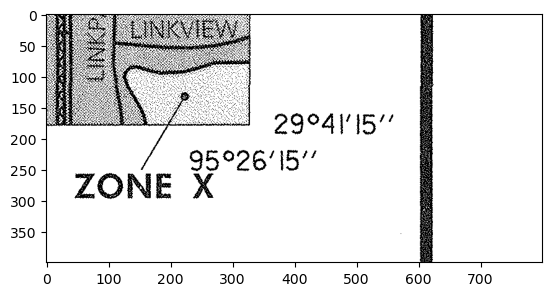

In [ ]:
import re

def clean_and_convert_coordinates(raw_coords):
    """
    Clean and convert a list of raw OCR-extracted coordinates to decimal degrees.

    Parameters:
        raw_coords (list of str): Raw OCR strings containing coordinates.

    Returns:
        list of tuple: List of cleaned and converted coordinates as (latitude, longitude).
    """
    def clean_coordinate(coord):
        # Remove unwanted symbols and normalize
        """coord = re.sub(r"[=]", "", coord)
        coord = coord.replace("'", "")
        coord = coord.replace('"', "")
        coord = coord.replace('°', '')
        coord = coord.replace('*', '')
        coord = coord.strip()"""

        coord = re.sub('[^0-9]','', coord)


        match = re.match(r"^(\d{3})(\d{4})", coord)


        if match:
            degrees_part = match.group(1)[:-1]  # Remove trailing '0' from degrees
            coord = degrees_part + match.group(2)
        
        return coord

    def parse_and_convert(coord):
        # Match patterns for degrees, minutes, and seconds
        match = re.match(r"(\d{2})+(\d{2})+(\d{2})", coord)
        if not match:
            return None
        degrees = int(match.group(1))
        minutes = int(match.group(2)) if match.group(2) else 0
        seconds = int(match.group(3)) if match.group(3) else 0
        # Convert to decimal degrees
        return degrees + minutes / 60 + seconds / 3600

    cleaned_coords = []
    for raw_coord in raw_coords:
        coord = clean_coordinate(raw_coord)
        decimal_coord = parse_and_convert(coord)
        if decimal_coord is not None:
            cleaned_coords.append(decimal_coord)
    
    return cleaned_coords

lon_range = (90, 100)
lat_range = (25, 35)

for key in out_sectors.keys():
    print(key)
    out_sectors[key]["coords"] = {}
    for k, v in out_sectors[key]['images'].items():

        coord_dict = {"lon" : None, "lat" : None}
        # for x in reader.readtext(v, detail=0, text_threshold=0.9):
        # print(clean_and_convert_coordinates([x]))

        detected_texts  = reader.readtext(v, detail=0, text_threshold=0.9)
        detected_coords = clean_and_convert_coordinates(detected_texts)

        # print(detected_texts)

        for x in detected_coords: 
            if lon_range[0] < x < lon_range[1]:
                coord_dict["lon"] = x
            if lat_range[0] < x < lat_range[1]:
                coord_dict["lat"] = x

        out_sectors[key]["coords"][k] = coord_dict

        if False:
            if coord_dict["lon"] is None or coord_dict["lat"] is None:
                print(detected_texts)
                plt.imshow(v)

    print(out_sectors[key]["coords"])

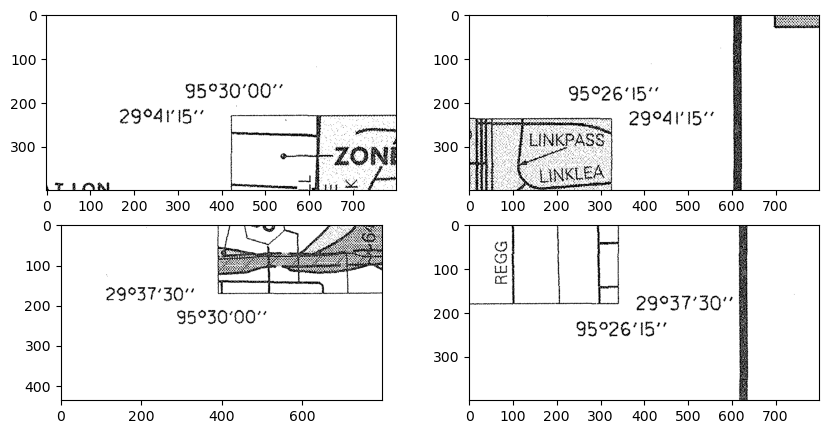

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0][0].imshow(out_sectors[key]['images']['top left'])
axs[0][1].imshow(out_sectors[key]['images']['top right'])
axs[1][0].imshow(out_sectors[key]['images']['bottom left'])
axs[1][1].imshow(out_sectors[key]['images']['bottom right'])